In [1]:
import sys
sys.path.extend(['..', '../bprime'])
    
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import itertools
import numpy as np
import msprime
from bprime import tools
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, train_test_split, cross_val_score


In [195]:
def standardize(x):
    return (x-np.mean(x))/np.std(x)

def data_transformer(X, transforms):
    fields = X.dtype.fields
    Xtrans = np.empty((X.shape[0], len(transforms)))
    colnames = list(X.dtype.fields.keys())
    for i, (colname, func) in enumerate(transforms.items()):
        if func is None:
            Xtrans[:, i] = X[colname]
        else:
            Xtrans[:, i] = func(X[colname])
    dtypes = [(c, fields[c][0]) for c in transforms]
    return Xtrans

In [207]:
TRAINING_DIR = '../data/slim_sims/segment/'

sim_params = dict(N=int, mu=float, h=float, s=float, rbp=float, recfrac=float, seglen=int)
X, y = tools.trees_to_training_data(TRAINING_DIR, params=sim_params, windows=[0, 100], progress=True)
pi, log10_B, n = y[:, 0], np.log10(y[:, 1]), y[:, 2]
X.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:02<00:00, 91.08it/s]


(194,)

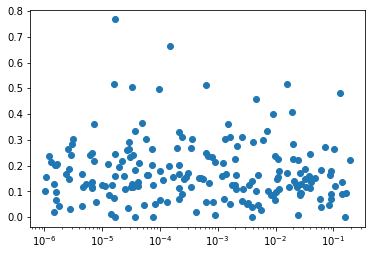

In [218]:
fig, ax = plt.subplots()
ax.scatter(X['s'], y[:, 3])
ax.set_xscale('log')

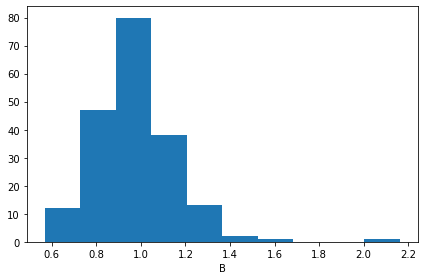

In [184]:
fig, ax = plt.subplots()
ax.hist(10**log10_B)
ax.set_xlabel('B')
plt.tight_layout()

In [201]:
Xt = data_transformer(X, dict(mu=np.log10, s=np.log10, rbp=None, recfrac=np.log10, seglen=None))
assert(np.all(np.isfinite(Xt)))

In [202]:
model = RandomForestRegressor(n_estimators = 1000)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, Xt, log10_B, scoring='explained_variance', cv=cv, n_jobs=-1, error_score='raise')
print('explained variance: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

explained variance: 0.042 (0.098)


In [203]:
X_train, X_test, y_train, y_test = train_test_split(Xt, log10_B, random_state=0)

In [204]:
model = RandomForestRegressor(n_estimators = 300)
model.fit(X_train, y_train)
model.score(X_test, y_test)

-0.16449143903150754

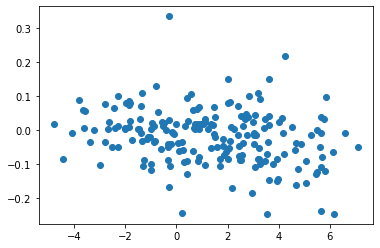

In [205]:
plt.scatter(Xt[:, 1] - Xt[:, 3], log10_B)

In [23]:
def predict_grid(params):
    grid_entries = []
    for param, specifier in params.items():
        if len(specifier) == 1:
            grid_entries.append(specifier)
        if len(specifier) == 3 or len(specifier) == 4:
            use_log10 = False
            if len(specifier) == 4:
                use_log10 = specifier == 'log10'
            lower, upper, size = specifier[:3]
            grid = np.linspace(lower, upper, size)
            if use_log10:
                grid = 10**grid
            grid_entries.append(grid)
    full_grid = []
    return np.stack((itertools.product(*grid_entries)))
        

predict_grid(dict(N=(2, 4, 10, 'log10'), 
                  mu=(5e-8, 5e-7, 10, 'log10'),
                  h=(0.5, ), 
                  s=(-6, np.log10(0.2), 10), 
                  rbp=(0.01/1e8, 30/1e8, 10), 
                  recfrac=(-8, np.log10(0.5)), 
                  seglen=(2, 4, 10, 'log10')))


/home/vsb/miniconda3/envs/bgcls/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[ 2.00000000e+00,  5.00000000e-08,  5.00000000e-01,
        -6.00000000e+00,  1.00000000e-10,  2.00000000e+00],
       [ 2.00000000e+00,  5.00000000e-08,  5.00000000e-01,
        -6.00000000e+00,  1.00000000e-10,  2.22222222e+00],
       [ 2.00000000e+00,  5.00000000e-08,  5.00000000e-01,
        -6.00000000e+00,  1.00000000e-10,  2.44444444e+00],
       ...,
       [ 4.00000000e+00,  5.00000000e-07,  5.00000000e-01,
        -6.98970004e-01,  3.00000000e-07,  3.55555556e+00],
       [ 4.00000000e+00,  5.00000000e-07,  5.00000000e-01,
        -6.98970004e-01,  3.00000000e-07,  3.77777778e+00],
       [ 4.00000000e+00,  5.00000000e-07,  5.00000000e-01,
        -6.98970004e-01,  3.00000000e-07,  4.00000000e+00]])

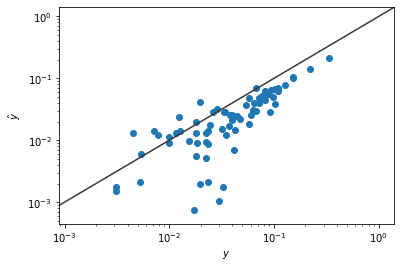

In [200]:
# in-sample prediction
model.fit(Xt, log10_B)
yhat = model.predict(Xt)

fig, ax = plt.subplots()
ax.scatter(log10_B, yhat)
ax.set_xlabel('$y$')
ax.set_ylabel('$\hat{y}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.axline((0, 0), (1, 1), c='0.22')

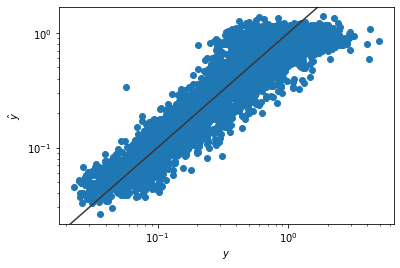

In [39]:
# out-sample prediction
model.fit(X_train, y_train)
yhat_test = model.predict(X_test)

fig, ax = plt.subplots()
ax.scatter(10**y_test, 10**yhat_test)
ax.set_xlabel('$y$')
ax.set_ylabel('$\hat{y}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.axline((0, 0), (1, 1), c='0.22')

(array([ 611., 3164., 4059., 3818., 3015., 1228., 1149., 1167., 1120.,
         669.]),
 array([-6.56877958, -5.94290336, -5.31702715, -4.69115094, -4.06527473,
        -3.43939852, -2.81352231, -2.18764609, -1.56176988, -0.93589367,
        -0.31001746]),
 <BarContainer object of 10 artists>)

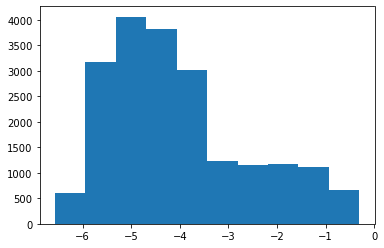

In [42]:
# what's mu/sh distribution in all the data?
plt.hist(Xt[:, 1]-Xt[:, 3])

In [43]:
def B_segment_lazy(rbp, L, s):
    """
    TODO check rbp = 0 case
    rt/ (b*(-1 + t) - t) * (b*(-1 + t) + r*(-1 + t) - t)
    """
    r = rbp*L
    a = -s*L # numerator -- ignores u
    b = (1-s)**2  # rf^2 terms
    c = 2*s*(1-s)+r*(1-s)**2 # rf terms
    d = s**2 + r*s*(1-s) # constant terms
    return a, b, c, d

def B_segment(mu, rf, rbp, L, s):
    a, b, c, d = B_segment_lazy(rbp, L, s)
    x = mu * a/(b*rf**2 + c*rf + d)
    return x

In [46]:
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300)

/home/vsb/miniconda3/envs/bgcls/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


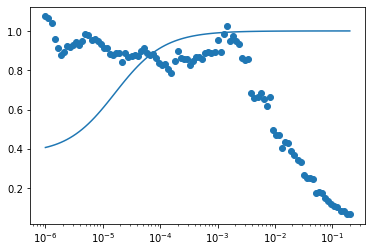

In [127]:
@np.vectorize
def bgs(mu, seglen, rbp, s):
    U = mu*seglen
    r = np.repeat(rbp, seglen)
    return np.exp(-U / np.sum((s*(s + (1-s)*r/s)**2)))

#dict(N=np.log10, mu=np.log10, h=None, s=np.log10, rbp=None, recfrac=np.log10, seglen=None))

rf = 1e-8
s_range = (-6, np.log10(0.2), 100)
L = 1000
rbp = 1e-8
mu = 1e-8


Xp = predict_grid(dict(N=(3, ), 
                  mu=(np.log10(mu), ),
                  h=(0.5, ), 
                  s=s_range, 
                  #s=(-3, ), 
                  rbp=(1e-8, ), 
                  #recfrac=(-6, np.log10(0.1), 100),
                  recfrac=(np.log10(rf), ),
                  seglen=(L, )))

yhat = model.predict(Xp)

fig, ax = plt.subplots()
ax.scatter(10**Xp[:, 3], 10**yhat)
s = 10**np.linspace(*s_range)
ax.plot(s, np.exp(B_segment(mu=mu, rf=rf, rbp=rbp, L=L, s=s)))
ax.set_xscale('log')
#ax.set_ylim(0, 2)

In [51]:
np.exp(-10**-1.2), np.exp(-10**-0.2), np.exp(-10**0)

(0.9388535887565691, 0.5320821711705858, 0.36787944117144233)

/home/vsb/miniconda3/envs/bgcls/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


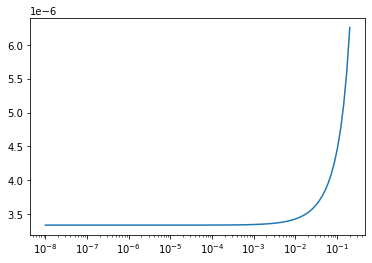

In [48]:

rf_range = (-8, np.log(0.5), 100)
s = -3
L = 1000
rbp = 1e-8
mu = 1e-8


Xp = predict_grid(dict(N=(3, ), 
                  mu=(np.log10(mu), ),
                  h=(0.5, ), 
                  s=(s, ), 
                  rbp=(1e-8, ), 
                  recfrac=rf_range,
                  seglen=(L, )))

yhat = model.predict(Xp)

fig, ax = plt.subplots()
#ax.scatter(10**Xp[:, 5], yhat)
rf = 10**np.linspace(*rf_range)
ax.plot(rf, B_segment(mu=mu, rf=rf, rbp=rbp, L=L, s=s))
ax.set_xscale('log')
#ax.set_ylim(0, 2)

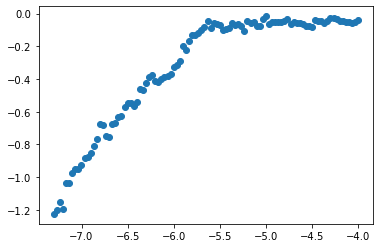

In [584]:
plt.scatter(np.log10(10**Xp[:, 1]/10**Xp[:, 3]), yhat)

(array([ 27., 121., 168., 113., 123., 108., 130., 141., 115.,  59.]),
 array([-6.49082323, -5.87435251, -5.25788178, -4.64141105, -4.02494032,
        -3.40846959, -2.79199887, -2.17552814, -1.55905741, -0.94258668,
        -0.32611596]),
 <BarContainer object of 10 artists>)

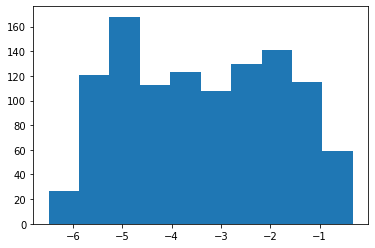

In [381]:
plt.hist(np.log10(X[:, 1]/X[:, 3]))

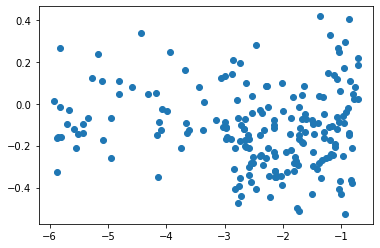

In [57]:
def nearest_data(X, y, points, k=200):
    if not isinstance(points, np.ndarray):
        points = np.array(points)
    dist = np.nansum((X - points[None, :])**2, axis=1)
    idx = np.argsort(dist)[:k]
    return X[idx, :], y[idx]

#dict(N=np.log10, mu=np.log10, h=None, s=np.log10, rbp=None, recfrac=np.log10, seglen=None))

Xn, yn = nearest_data(Xt, log10_B, (3, -7, 0.5, np.nan, 1e-8, -8, 10000))
plt.scatter(Xn[:, 3], yn)

In [61]:
10**-0, 10**-0.4

(1, 0.3981071705534972)

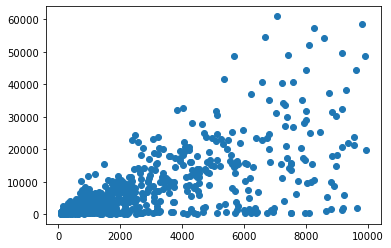

In [246]:
plt.scatter(X[:, 0], y)